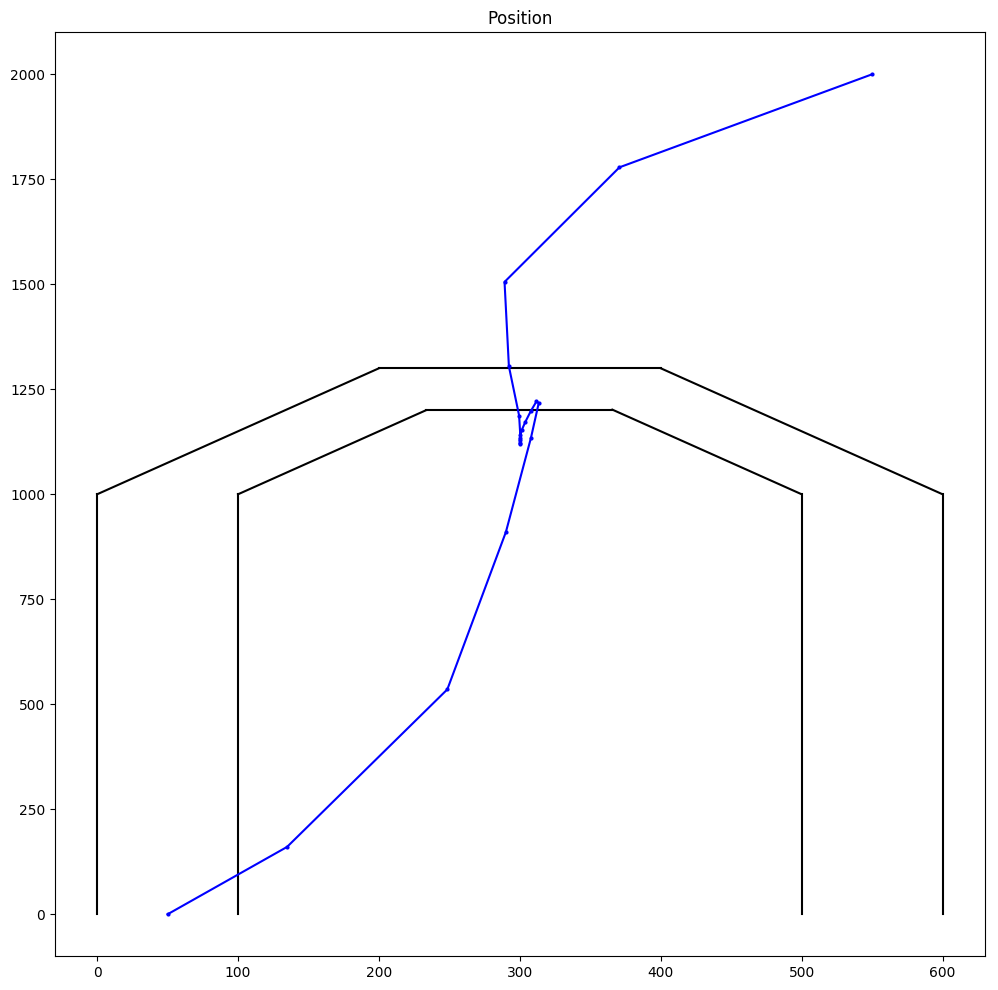

In [108]:
using JuMP, Gurobi, Mosek, PyPlot
coflo = 0.2 #coeffecient of friction longitudnal(in direction of motion)
cofla = 0.4 #coeffecient of friction lattitudnal(perpendicular to direction of motion of the front tyers when they turn)


## car specs all specs in meters and seconds
# mass = 1000 # in kg
g = 9.8  # gravitational pull in m/sec^2
maxacc = 600.5 # max acc in m/sec^2
maxv = 5500.55 # max velocity in m/sec equivalent to 200km/hr
maxTu = 1.27 #max steer one side

k = 20
startPos = [50,0]
finishPos = [550,2000]
# finishPos = [25000,180000]
startVel = [0,10]
finishVel = [0,0]
finishAcc = [0,0]


    # define waypoints
    # m = Model(solver = GurobiSolver(OutputFlag=0))
    m = Model(solver = MosekSolver(LOG=0))
    
    @variable(m, P[1:2,1:k])  # resulting position in x,y
    @variable(m, v[1:2,1:k])
    @variable(m, -(2*maxacc) <= Acc[1:2,1:k] <= maxacc )

    # satisfy the dynamics (with zero initial velocity)
    @constraint(m, P[:,1] .== startPos)
#     @constraint(m, P[:,k] .== finishPos)
    @constraint(m, v[:,1] .== startVel)
    # @constraint(m, v[:,k] .== finishVel)
    # @constraint(m, AccDM[:,k] .== finishAcc)
    @expression(m, finishDistance, sum((P[i,k]-finishPos[i])^2 for i in 1:2))

#     for t in 1:10
#         @constraint(m, P[1,t] <= 100)
#     end
#     for t in 11:17
#         @constraint(m, P[2,t] >= 2000 + 10t)
#     end
#     for t in 18:20
#         @constraint(m, P[2,t] <= 2300 - 10t)
#     end

    for t in 1:k
        @constraint(m, (v[1,t]^2)+(v[2,t]^2) <= maxv^2)
        @constraint(m, P[1,t] >= 0)
        @constraint(m, P[1,t] <= 600)
        @constraint(m, P[2,t] >= 0)
        @constraint(m, P[2,t] <= 2300)
    end

    for t in 1:k-1
#         @constraint(m, Acc[:,t+1] .== Acc[:,t] 
        @constraint(m, v[1,t+1] == v[1,t] + Acc[1,t])
        @constraint(m, v[2,t+1] == v[2,t] + Acc[2,t])
        @constraint(m, P[1,t+1] == P[1,t] + v[1,t] + (.5)*(Acc[1,t]) )
        @constraint(m, P[2,t+1] == P[2,t] + v[2,t] + (.5)*(Acc[2,t])  )   
    end


                
                
     @objective(m, Min, finishDistance)               
    solve(m)
    
rad = linspace(0,π,100) 

x = 300 + 300*cos.(rad)
y = 2000 +300*sin.(rad)
x1 = 300 + 200*cos.(rad)
y1 = 2000 + 200*sin.(rad)

x2 = linspace(0,200,100)
x3 = linspace(100,233.33,100)
x4 = linspace(233.33,365.66,100)
x5 = linspace(200,400,100)
x6 = linspace(365.66,500,100)
x7 = linspace(400,600,100)

y2 = (3/2)*x2 + 1000
y3 = (3/2)*x3 + 850
y4 = 0*x4 + 1200
y5 = 0*x5 + 1300
y6 = -(3/2)*x6 + 1750
y7 = -(3/2)*x7 + 1900

Llinex = [0, 0]
Lliney = [0, 1000]
LMlinex = [100,100]
LMliney = [0,1000]
RMlinex = [500, 500]
RMliney = [0,1000]
Rlinex = [600,600]
Rliney = [0,1000]

figure(figsize=(12,12))
title("Position")

plot(Llinex[:],Lliney[:], color = "#000000", markersize=4 )
plot(LMlinex[:],LMliney[:],color = "#000000", markersize=4 )
plot(RMlinex[:],RMliney[:], color = "#000000", markersize=4 )
plot(Rlinex[:],Rliney[:], color = "#000000", markersize=4 )
# plot(x,y, color = "#000000", markersize=4 )
# plot(x1,y1, color = "#000000", markersize=4 )
plot(x2,y2, color = "#000000", markersize=4 )
plot(x3,y3, color = "#000000", markersize=4 )
plot(x4,y4, color = "#000000", markersize=4 )
plot(x5,y5, color = "#000000", markersize=4 )
plot(x6,y6, color = "#000000", markersize=4 )
plot(x7,y7, color = "#000000", markersize=4 )

plot( getvalue(P[1,:]), getvalue(P[2,:]), "b.-", markersize=4 );